In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from statsmodels.graphics.tsaplots import plot_pacf

from darkgreybox.models import DarkGreyModel, Ti, TiTe, TiTh, TiTeTh, TiTeThRia
from darkgreybox.fit import darkgreyfit
from docs.tutorials.util.plot import plot
from docs.tutorials.util.error import rmse

2021-03-30 13:34:07,631 darkgreybox  INFO     Logging enabled...


## Demo Notebook 04 - DarkGreyFit

This notebook demonstrates the usage of the `DarkGreyBox` models via fitting them with `DarkGreyFit`, setting up and evaluating multiple pipelines at once.


Our temporal resolution is 1 hour

In [2]:
# the duration of a record
rec_duration = 1 # hour

Read some demo data.  
* Ph: Heating system power output
* Ta: Ambient temperature
* Ti: Internal temperature

We are also setting a set of custom fields in our input data: `Ti0`, `Th0` and `Te0`. These fields define the initial conditions for `Ti`, `Th` and `Te` for each record of the input data respectively. E.g. if a sub-model is trained based on the 10-20 records of the training data, the initial conditions for the above params will be set by the 10. record of the input data. 

Note: This demo data is intentionally far from ideal and particularly challenging to model with low errors. It is taken from a building where there are many factors influencing the heat dynamics of the building that are not accounted for in the modelling (solar gains, passive gains, hot water demand, gas use in the canteen etc.). The time period is relatively short to maintain a reasonable solution time for the demo. However, it includes an also challenging holiday period when the heating system is shut down.

In [3]:
train_df = pd.read_csv('./data/demo_data.csv', index_col=0, parse_dates=True)

input_X = train_df[['Ph', 'Ta', 'Th']]
input_y = train_df['Ti']

input_X['Ti0'] = input_y
input_X['Th0'] = input_y
input_X['Te0'] = input_y - 2 

print(f'Input X shape: {input_X.shape}, input y shape: {input_y.shape}')

Input X shape: (792, 6), input y shape: (792,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, test_size=5 / 33, shuffle=False)

print(f'Train: X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test: X shape: {X_test.shape}, y shape: {y_test.shape}')

Train: X shape: (672, 6), y shape: (672,)
Test: X shape: (120, 6), y shape: (120,)


Set up the model training parameters for each model instance that we want to spin up in the pipeline.  

The `Ti0` param is the initial condition for the internal temperature at t=0 - this is set to the first record of `X_train['Ti0']` as described above and is fixed, hence `vary: False`.  

The `Te0` param is the initial condition for the building envelope temperature at t=0 - - this is set to the first record of `X_train['Te0']` as described above and is NOT fixed, hence `vary: True`.  

The `Th0` param is the initial condition for the heating system temperature at t=0 - - this is set to the first record of `X_train['Th0']` as described above and is NOT fixed, hence `vary: True`.  

`Ci`, `Ce`, `Rie` and `Ria` params are the initial conditions for these thermal parameters. As these will be fit by the model training their default is `vary: True`. The values for these params' initial conditions are set arbitrarily to `1` it is assumed that no estimates have been calculated for them (e.g. based on building physical properties).

Note that we've added the `Ch` and `Rih` params with set initial conditions not allowed to vary. These are the RC params for the heating system and their values have been precalculated from the heating system's time constant to make this example simpler.


In [5]:
train_params_Ti = {
    'Ti0': {'value': X_train.iloc[0]['Ti0'], 'vary': False},
    'Ci': {'value': 1},
    'Ria': {'value': 1},
}

train_params_TiTe = {
    'Ti0': {'value': X_train.iloc[0]['Ti0'], 'vary': False},
    'Te0': {'value': X_train.iloc[0]['Ti0'], 'vary': True},
    'Ci': {'value': 1},
    'Ce': {'value': 1},
    'Rie': {'value': 1},
    'Rea': {'value': 1},
}

train_params_TiTh = {
    'Ti0': {'value': X_train.iloc[0]['Ti0'], 'vary': False},
    'Th0': {'value': X_train.iloc[0]['Th0'], 'vary': False},    
    'Ci': {'value': 1},
    'Ch': {'value': 2.55, 'vary': False},
    'Ria': {'value': 1},
    'Rih': {'value': 0.65, 'vary': False}
}

train_params_TiTeTh = {
    'Ti0': {'value': X_train.iloc[0]['Ti0'], 'vary': False},
    'Te0': {'value': X_train.iloc[0]['Te0'], 'vary': True, 'min': 10, 'max': 25},
    'Th0': {'value': X_train.iloc[0]['Th0'], 'vary': False},    
    'Ci': {'value': 1},
    'Ch': {'value': 2.55, 'vary': False},
    'Ce': {'value': 1},
    'Rie': {'value': 1},
    'Rea': {'value': 1},
    'Rih': {'value': 0.65, 'vary': False}
}

train_params_TiTeThRia = {
    'Ti0': {'value': X_train.iloc[0]['Ti0'], 'vary': False},
    'Te0': {'value': X_train.iloc[0]['Te0'], 'vary': True, 'min': 10, 'max': 25},
    'Th0': {'value': X_train.iloc[0]['Th0'], 'vary': False},    
    'Ci': {'value': 1},
    'Ch': {'value': 2.55, 'vary': False},
    'Ce': {'value': 1},
    'Rie': {'value': 1},
    'Rea': {'value': 1},
    'Ria': {'value': 1},
    'Rih': {'value': 0.65, 'vary': False}
}

Set up our initial conditions parameters map for testing

In [6]:
ic_params_map = {
    'Ti0': lambda X_test, y_test, train_result: y_test.iloc[0],
    'Th0': lambda X_test, y_test, train_result: y_test.iloc[0],
    'Te0': lambda X_test, y_test, train_result: train_result.Te[-1],
}

We can instantiate a range of models to be evaluated - in this case we are setting up 5 different models starting from the simplest `Ti` to `TiTeThRia` with medium complexity.


In [7]:
models = [Ti(train_params_Ti, rec_duration),
          TiTe(train_params_TiTe, rec_duration),
          TiTh(train_params_TiTh, rec_duration),
          TiTeTh(train_params_TiTeTh, rec_duration),
          TiTeThRia(train_params_TiTeThRia, rec_duration)]

We need to split our training data set into managable chunks for the prefit stage. `Sklearn` is quite helpful here again, in case we wanted to define the prefit sets to be 1 day (24 hours) long:

In [8]:
prefit_splits = KFold(n_splits=int(len(X_train) / 24), shuffle=False).split(X_train)

To evaluate the performance of our models we will need to define an error metric. Again, there is a wide range of options available from `sklearn`:

In [9]:
error_metric = rmse

We can define a prefit "survival threshold" to trim the number of model fits during the training process. Any models achieving a higher error during the prefit stage will not make it into the training stage.

In [10]:
prefit_filter = lambda error: abs(error) < 2

Under the hood, `DarkGreyBox` uses `lmfit.minimize` to fit the thermal model parameters to the training data by passing it a custom objective function defined by the model class. The fit method used by `lmfit.minimize` can be customised as well, and while the standard Nelder-Mead and Levenberg-Marquardt methods work well in general, it is worth experimenting with others (see here for a list of supported methods: https://lmfit.github.io/lmfit-py/fitting.html#fit-methods-table).

In [11]:
method = 'nelder'

Setting up is ready! We only need to call the `darkgreyfit` convenience pipeline function that delegates the work to the prefit, train and test low-level procedures running on multiple processes and reducing / cleaning the interim results. The returned `pandas.DataFrame` contains the fit models and their train/test performance evaluation.   


In [12]:
df = darkgreyfit(models, X_train, y_train, X_test, y_test, ic_params_map, error_metric,
                 prefit_splits=prefit_splits, prefit_filter=prefit_filter, reduce_train_results=True, 
                 method=method, n_jobs=-1, verbose=10)

2020-12-01 21:44:14,212 darkgreybox  INFO     Training models...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min


2020-12-01 21:45:32,850 darkgreybox  INFO     Training models...


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.2min


2020-12-01 21:50:29,495 darkgreybox  INFO     Generating predictions for 11 models...


[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:  4.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.5s finished


In this specific example:
* *Initial Population:* 5 model structures were prefit to 28x 24-hour data chunks resulting in 140 pipelines
* *Fitness Function:* The RMSE of a prefit had to be < 2˚C to survive
* *Selection:* 110 pipelines survived the prefit selection and made it into training on the entire training set 
* (No *Crossover* or *Mutation*)
* *Termination:* Out of the 110 pipelines trained, 11 distinct model results were found (i.e. many pipelines were arriving at the same parameter set results)

In [13]:
df

train                            \
                  start_date                  end_date   
0  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
1  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
2  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
3  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
4  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
5  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
6  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
7  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
8  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
9  2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   
10 2019-12-23 00:00:00+00:00 2020-01-19 23:00:00+00:00   

                                                       \
                                                model   
0   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
1   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
2   <darkgreybox.model.TiTeTh object at 0x7fdb36fe...   
3   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
4     <darkgreybox.model.Ti object at 0x7fdb331a63d0>   
5   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
6   <darkgreybox.model.TiTh object at 0x7fdb380491c0>   
7   <darkgreybox.model.TiTe object at 0x7fdb36d4df70>   
8   <darkgreybox.model.TiTe object at 0x7fdb36fea8b0>   
9   <darkgreybox.model.TiTe object at 0x7fdb36e0adf0>   
10  <darkgreybox.model.TiTh object at 0x7fdb36f49e80>   

                                                                          \
                                         model_result       time  method   
0   <darkgreybox.model.DarkGreyModelResult object ...  56.752904  nelder   
1   <darkgreybox.model.DarkGreyModelResult object ...  79.603448  nelder   
2   <darkgreybox.model.DarkGreyModelResult object ...   9.489066  nelder   
3   <darkgreybox.model.DarkGreyModelResult object ...  23.151365  nelder   
4   <darkgreybox.model.DarkGreyModelResult object ...   0.455989  nelder   
5   <darkgreybox.model.DarkGreyModelResult object ...  36.217800  nelder   
6   <darkgreybox.model.DarkGreyModelResult object ...   1.256503  nelder   
7   <darkgreybox.model.DarkGreyModelResult object ...  11.741584  nelder   
8   <darkgreybox.model.DarkGreyModelResult object ...  61.664101  nelder   
9   <darkgreybox.model.DarkGreyModelResult object ...  61.399544  nelder   
10  <darkgreybox.model.DarkGreyModelResult object ...   4.051015  nelder   

                                  test                            \
       error                start_date                  end_date   
0   0.371872 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
1   0.444083 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
2   0.450460 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
3   0.833691 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
4   0.864781 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
5   0.921897 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
6   0.925848 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
7   1.396299 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
8   1.531621 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
9   1.563156 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   
10  1.565403 2020-01-20 00:00:00+00:00 2020-01-24 23:00:00+00:00   

                                                       \
                                                model   
0   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
1   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
2   <darkgreybox.model.TiTeTh object at 0x7fdb3314...   
3   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
4     <darkgreybox.model.Ti object at 0x7fdb331a6160>   
5   <darkgreybox.model.TiTeThRia object at 0x7fdb3...   
6   <darkgreybox.model.TiTh object at 0x7fdb331a6c10>   
7   <darkgreybox.model.TiTe object at 0x7fdb36dfebe0>   
8   <darkgreybox.model.TiTe object at 0x7fdb3804df70>   
9   <darkgreybox.model.Ti

We can select the model with the lowest error and display its params

In [14]:
select_idx = df[('train', 'error')].argmin()

model = df.loc[select_idx, ('train', 'model')]
train_results = df.loc[select_idx, ('train', 'model_result')]
test_results = df.loc[select_idx, ('test', 'model_result')]

model.result.params

name,value,initial value,min,max,vary
Ti0,18.1375000,18.1375,-inf,inf,False
Te0,18.8064057,16.1375,10.0000000,25.0000000,True
Th0,18.1375000,18.1375,-inf,inf,False
Ci,156.988719,140.31495334559543,-inf,inf,True
Ch,2.55000000,2.55,-inf,inf,False
Ce,389.155693,30.9844968286637,-inf,inf,True
Rie,0.11065590,0.21214648000429043,-inf,inf,True
Rea,4.0578e+11,0.2886086408479051,-inf,inf,True
Ria,0.63718670,11.325000607900307,-inf,inf,True
Rih,0.65000000,0.65,-inf,inf,False


The results show that the `TiTeThRia` model has a good fit on the training set (R2=0.9612) and the errors are low for both the training and test sets (RMSE 0.3719 and 0.3383 respectively) indicating that the model generalises well for data it hasn't seen before (no overfitting problem).

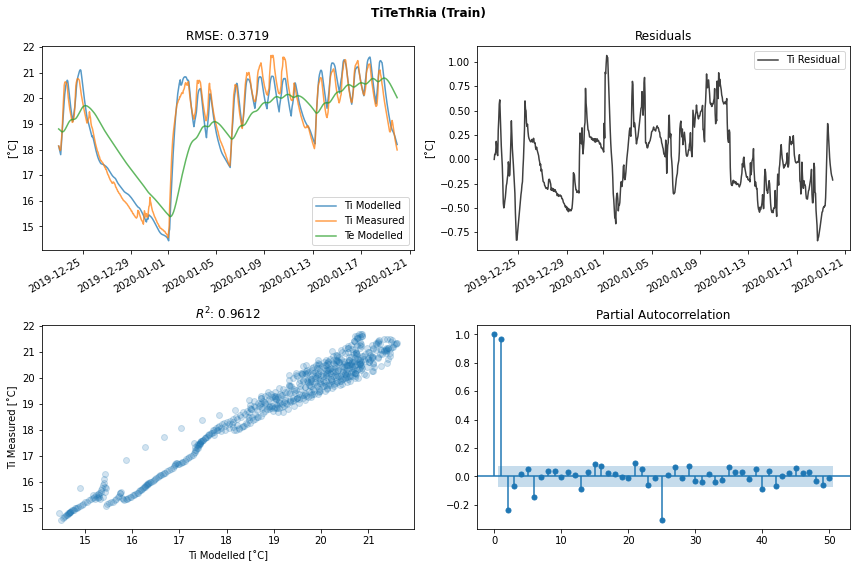

In [15]:
plot(y_train, train_results, 'TiTeThRia (Train)')

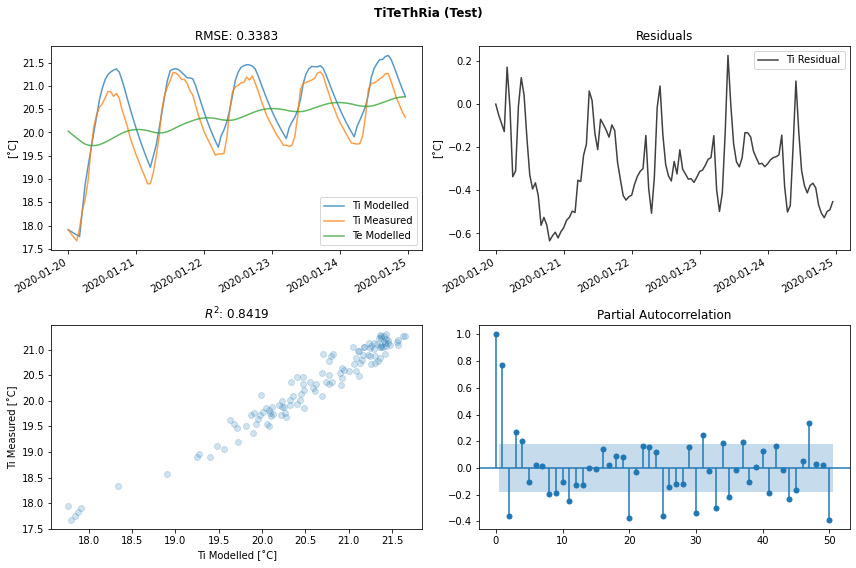

In [16]:
plot(y_test, test_results, 'TiTeThRia (Test)')

In contrast, the `Ti` model has a poor fit on the training set (R2=0.79) which is clear from the temperature plots as well. Due to low model complexity there is a definite underfitting problem going in here, which of course also results in poor test set performance. This is hardly surprising, as the `Ti` model only keeps internal states of the internal temperatures (`Ti`) and it is unaware of the internal states of the heating system / building envelope temperatures  (`Th` and `Te` respectively) - both of which are important for describing the system components' thermal inertia.

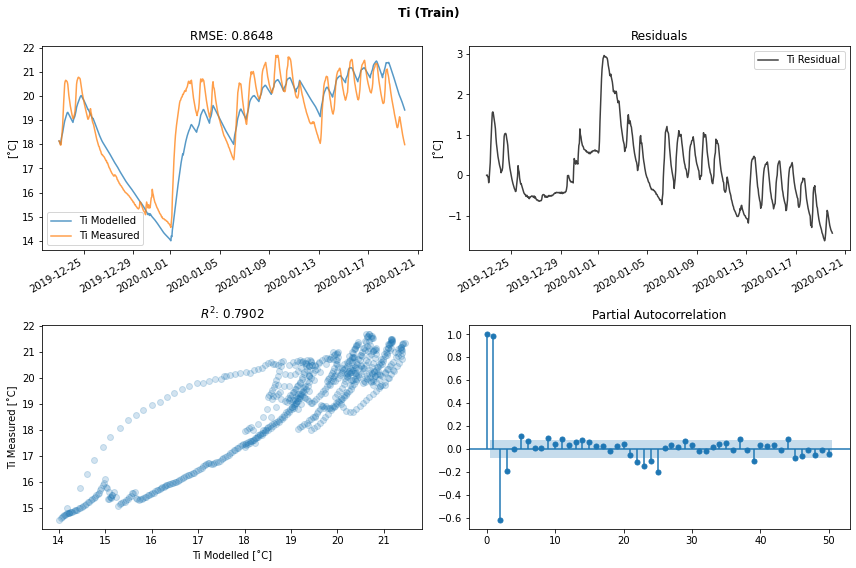

In [17]:
plot(y_train, df.loc[4, ('train', 'model_result')], 'Ti (Train)')

/Users/quarentine/.virtualenvs/darkgreybox/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


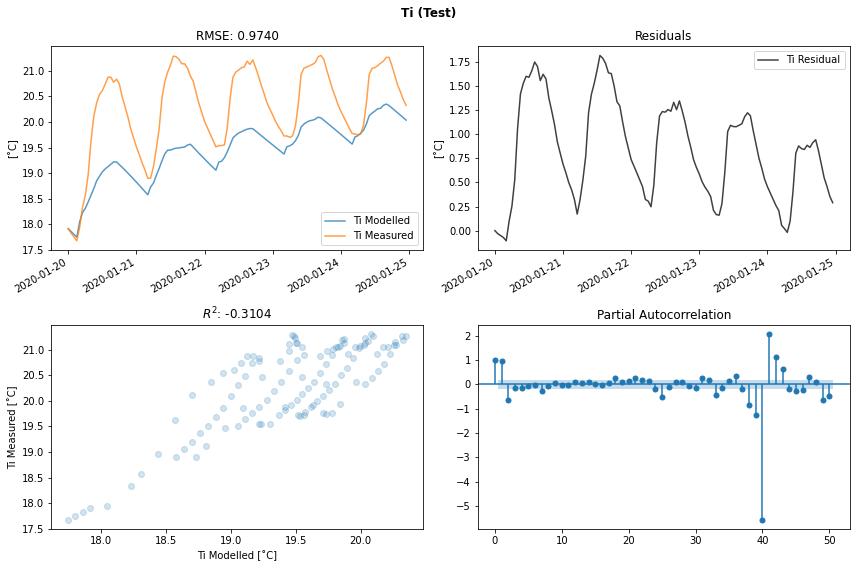

In [18]:
plot(y_test, df.loc[4, ('test', 'model_result')], 'Ti (Test)')